In [1]:
# Simplified phase noise and time jitter generator
# Goal: Generate low-pass filtered phase noise and convert it to time jitter noise
# Conversion: Δt = Δφ / (2π × f_carrier)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Set parameters
carrier_freq = 4e9      # 4 GHz carrier frequency
fs = 2300e9             # 2300 GHz sampling rate (about 1024 GHz)
symbol_rate = 500e6     # 500 MHz symbol rate
symbol_duration = 1 / symbol_rate  # 2ns per symbol

csv_file_path = '../csv/8PPM_D2PSK_500Mbps_t0.csv'
phase_noise_csv_path = '../csv/phase_noise_8ppm_d2psk_t0.csv'

phase_noise_std = 0  # radians
phase_noise_std_degree = phase_noise_std * 180 / np.pi
phase_noise_std_time = phase_noise_std / (2 * np.pi * carrier_freq)

print(f"Phase noise standard deviation: {phase_noise_std:.2f} radians / \
{phase_noise_std_degree:.2f} degrees / {phase_noise_std_time * 1e12:.2f} ps")

Phase noise standard deviation: 0.00 radians / 0.00 degrees / 0.00 ps


In [2]:
data = pd.read_csv(csv_file_path)
print(f"Successfully read data, shape: {data.shape}")
print(f"Data columns: {list(data.columns)}")

# Show basic statistics of the data
print(f"\nData statistics:")
print(data.describe())

Successfully read data, shape: (3255745, 2)
Data columns: ['time', 'data']

Data statistics:
               time          data
count  3.255745e+06  3.255745e+06
mean   2.500004e-06  3.450250e-03
std    1.443369e-06  6.790534e-02
min    0.000000e+00 -1.651894e-01
25%    1.249918e-06 -2.181840e-03
50%    2.499909e-06  1.718253e-05
75%    3.749961e-06  6.914080e-03
max    5.000000e-06  1.902422e-01


In [3]:
# generate phase noise
np.random.seed(42)
phase_noise = np.random.normal(0, phase_noise_std, len(data))

# Calculate time jitter noise
# Relationship between time jitter and phase noise: Δt = Δφ / (2π * f_carrier)
time_jitter = phase_noise / (2 * np.pi * carrier_freq)

In [4]:
# Prepare to save data

# Create output dataframe, keep only time and data columns
output_data = pd.DataFrame()

# Add time column
output_data['time'] = data['time']

# Apply time jitter noise to the original signal
# Get original time axis
t_original = np.array(data['time'].values)
t_jittered = t_original + time_jitter
data_original = np.array(data['data'].values)

# Use interpolation to get signal values at jittered time points
from scipy.interpolate import interp1d

# Create interpolation function
# Use linear interpolation, extrapolate for boundaries
interp_func = interp1d(t_original, data_original, 
                        kind='linear', 
                        bounds_error=False, 
                        fill_value=0)

# Sample at jittered time points
noisy_signal = interp_func(t_jittered)

output_data['data'] = noisy_signal

# save to csv
output_data.to_csv(phase_noise_csv_path, index=False)

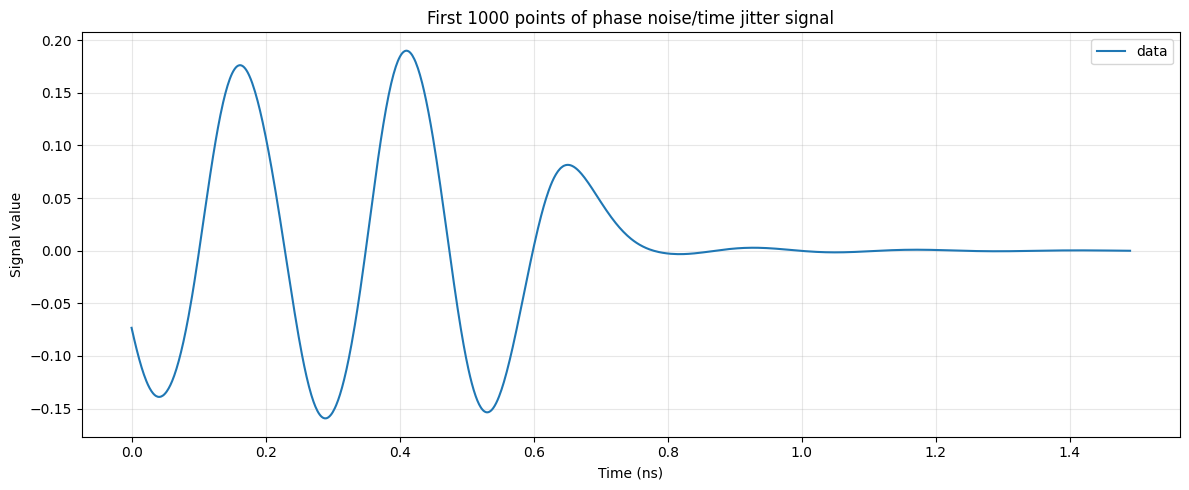

In [5]:
# Read and plot the first 1000 points
try:
	plot_data = pd.read_csv(phase_noise_csv_path, nrows=1000)
	plt.figure(figsize=(12, 5))
	plt.plot(plot_data['time'] * 1e9, plot_data['data'], label='data')
	plt.xlabel('Time (ns)')
	plt.ylabel('Signal value')
	plt.title('First 1000 points of phase noise/time jitter signal')
	plt.grid(True, alpha=0.3)
	plt.legend()
	plt.tight_layout()
	plt.show()
except Exception as e:
	print(f"Error reading or plotting: {e}")